## Problem 5 ##

## Pytorch tutorial is followed for solving the problem ##

In [1]:
%matplotlib inline
import torch
torch.backends.cuda.max_split_size_mb = 0

In [2]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

### 2 - Modifying the model to add a different backbone



### Object detection and instance segmentation model for PennFudan Dataset

In our case, we want to finetune from a pre-trained model, given that
our dataset is very small, so we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will
be using Mask R-CNN:



## Q-5(a) Adding a different backbone (option 2). ##

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# Option 1
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

# Option 2
def get_model_instance_segmentation_opt2(num_classes):
    # Use mobilenet_v2 backbone
    backbone = torchvision.models.efficientnet_v2_l(weights="DEFAULT").features
    # mobilenet_v2(weights="DEFAULT").features
    # backbone.classifier[1] = torch.nn.Conv2d(backbone.last_channel, 256, kernel_size=1)  # Adjust the output channels
    backbone.out_channels = 1280
    # Define the anchor generator and ROI pooler 
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1, 2.0),)
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=14,
        sampling_ratio=2
    )

    mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=28,
    sampling_ratio=2
    )


    # Create the Mask R-CNN model
    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        mask_roi_pool=mask_roi_pooler,
    )
    return model

That’s it, this will make ``model`` be ready to be trained and evaluated
on your custom dataset.

## Putting everything together

In ``references/detection/``, we have a number of helper functions to
simplify training and evaluating detection models. Here, we will use
``references/detection/engine.py`` and ``references/detection/utils.py``.
Just download everything under ``references/detection`` to your folder and use them here.
On Linux if you have ``wget``, you can download them using below commands:



In [4]:
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

# Since v0.15.0 torchvision provides `new Transforms API <https://pytorch.org/vision/stable/transforms.html>`_
# to easily write data augmentation pipelines for Object Detection and Segmentation tasks.
#
# Let’s write some helper functions for data augmentation /
# transformation:

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


# Testing ``forward()`` method (Optional)
# ---------------------------------------
#
# Before iterating over the dataset, it's good to see what the model
# expects during training and inference time on sample data.
import utils
# import torch.utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('./PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.3318, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0474, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0623, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0011, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


Let’s now write the main function which performs the training and the
validation:



In [5]:
# Training for Option-1 model

from engine import train_one_epoch, evaluate


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('./PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('./PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:02:18  lr: 0.000090  loss: 5.3844 (5.3844)  loss_classifier: 0.7377 (0.7377)  loss_box_reg: 0.3550 (0.3550)  loss_mask: 4.2576 (4.2576)  loss_objectness: 0.0289 (0.0289)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 2.3057  data: 0.8315  max mem: 2116
Epoch: [0]  [10/60]  eta: 0:00:21  lr: 0.000936  loss: 2.5501 (3.2811)  loss_classifier: 0.5115 (0.4825)  loss_box_reg: 0.2362 (0.2699)  loss_mask: 1.7508 (2.4974)  loss_objectness: 0.0170 (0.0269)  loss_rpn_box_reg: 0.0037 (0.0044)  time: 0.4313  data: 0.0805  max mem: 2853
Epoch: [0]  [20/60]  eta: 0:00:13  lr: 0.001783  loss: 0.8969 (2.0705)  loss_classifier: 0.1807 (0.3283)  loss_box_reg: 0.2326 (0.2568)  loss_mask: 0.4101 (1.4569)  loss_objectness: 0.0145 (0.0218)  loss_rpn_box_reg: 0.0040 (0.0067)  time: 0.2395  data: 0.0056  max mem: 2853
Epoch: [0]  [30/60]  eta: 0:00:09  lr: 0.002629  loss: 0.6593 (1.5987)  loss_classifier: 0.1377 (0.2553)  loss_box_reg: 0.2448 (0.2564)  loss_mask: 0.2426 (1.0628)  loss_ob

## Q-5(b) Training the model of Option 2 ##

In [6]:
# get the model using our helper function
model_opt2 = get_model_instance_segmentation_opt2(num_classes)

# move model to the right device
model_opt2.to(device)

# construct an optimizer
params = [p for p in model_opt2.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(
#     params,
#     lr=0.005,
#     momentum=0.9,
#     weight_decay=0.0005
# )
num_epochs = 5
optimizer = torch.optim.AdamW(
    params, 
    lr=1e-5, 
    weight_decay=5e-6
)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_opt2, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model_opt2, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:01:43  lr: 0.000000  loss: 29.1372 (29.1372)  loss_classifier: 0.7140 (0.7140)  loss_box_reg: 0.1033 (0.1033)  loss_mask: 27.4457 (27.4457)  loss_objectness: 0.7346 (0.7346)  loss_rpn_box_reg: 0.1396 (0.1396)  time: 1.7265  data: 0.5665  max mem: 21687
Epoch: [0]  [10/60]  eta: 0:00:44  lr: 0.000002  loss: 26.1189 (26.4662)  loss_classifier: 0.4397 (0.4779)  loss_box_reg: 0.0981 (0.0999)  loss_mask: 24.8110 (25.0107)  loss_objectness: 0.7514 (0.7509)  loss_rpn_box_reg: 0.1104 (0.1268)  time: 0.8853  data: 0.0558  max mem: 28284
Epoch: [0]  [20/60]  eta: 0:00:34  lr: 0.000004  loss: 24.2646 (24.0205)  loss_classifier: 0.2847 (0.3599)  loss_box_reg: 0.0794 (0.0893)  loss_mask: 23.0450 (22.7281)  loss_objectness: 0.7295 (0.7340)  loss_rpn_box_reg: 0.0999 (0.1091)  time: 0.8100  data: 0.0053  max mem: 28284
Epoch: [0]  [30/60]  eta: 0:00:25  lr: 0.000005  loss: 16.7256 (21.0132)  loss_classifier: 0.2644 (0.3355)  loss_box_reg: 0.0865 (0.0935)  loss_mask: 15.7280

So after one epoch of training, we obtain a COCO-style mAP > 50, and
a mask mAP of 65.

But what do the predictions look like? Let’s take one image in the
dataset and verify

<img src="file://../../_static/img/tv_tutorial/tv_image05.png">




Text(0.5, 1.0, 'Predition by Option 2')

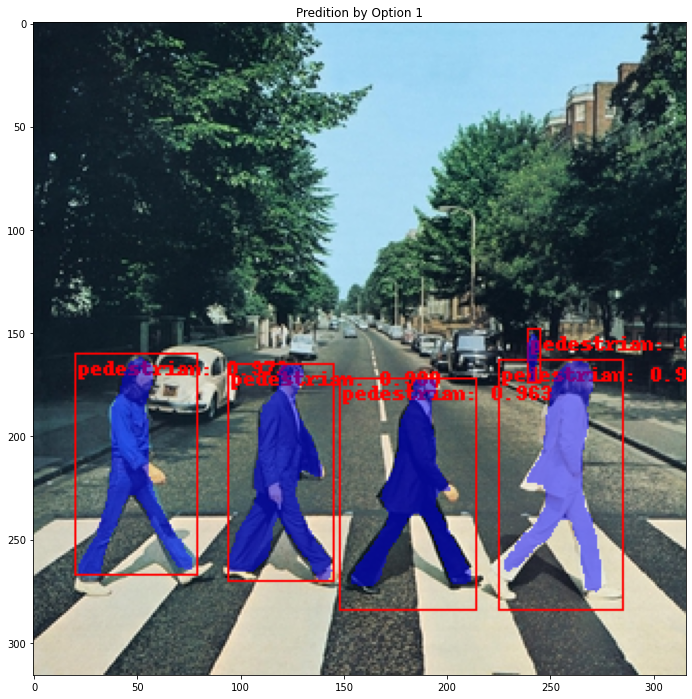

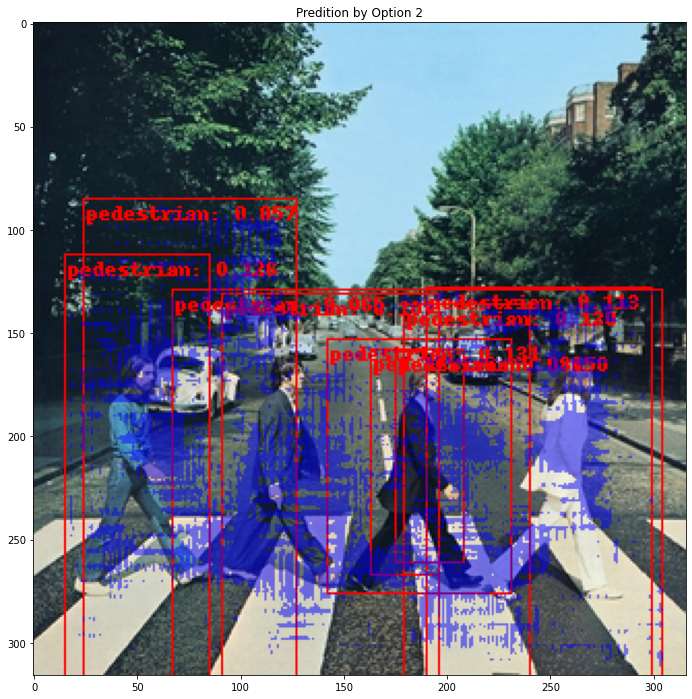

In [7]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("test_image.jpg") #  read_image("../_static/img/tv_tutorial/tv_image05.png")
eval_transform = get_transform(train=False)
model.eval()
model_opt2.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]
    
    predictions_opt2 = model_opt2([x, ])
    pred_opt2 = predictions_opt2[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
# Option 1
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.title("Predition by Option 1")

# Option 2
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred_opt2["labels"], pred_opt2["scores"])]
pred_boxes = pred_opt2["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred_opt2["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.title("Predition by Option 2")

Option 1 does better than option 2.
